# พลอตผลการ preprocessing radar moments จนถึงการจำแนกชนิดหยาดน้ำฟ้า

* 2022.12.18
* 1. การขจัด clutter กับ noise ใช้ SNR
* 2. การปรับแก้ค่า differential phase fields ได้แก่ Differential Phase Shift (ΦDP or PHI)  และคำนวณค่า Specific Differential Phase (KDP)
* 3. การปรับแก้ attenuation correction of reflectivity
* 4. จำแนกชนิดหยาดน้ำฟ้า HID/HCA
โค้ดหลักมาจากไฟล์ "004พลอตผลPreprocessing radar moments"

In [1]:
import numpy as np
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import pyart

#-for CSU Tool
from __future__ import print_function
import matplotlib.colors as colors
import glob
#from pyart.io.common import radar_coords_to_cart
from pyart.core.transforms import antenna_to_cartesian as radar_coords_to_cart # มันเปลี่ยนที่อยู่ไปเก็บไว้ที่ core C:\Users\Admin\anaconda3\envs\pyart\Lib\site-packages\pyart\core
from skewt import SkewT 
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain, 
                                csu_dsd, csu_kdp, csu_misc)
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



<frozen importlib._bootstrap>:283: DeprecationWarning: the load_module() method is deprecated and slated for removal in Python 3.12; use exec_module() instead
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\mpl_toolkits\basemap\__init__.py:33: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _matplotlib_version = LooseVersion(_matplotlib_version)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\mpl_toolkits\basemap\__init__.py:34: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _mpl_required_version = LooseVersion('0.98')
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\csu_radartools-1.3.0.dev0-py3.10-win-amd64.egg\csu_radartools\csu_misc.py:18: DeprecationWarning: Please use `label` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import label


In [2]:
def add_field_to_radar_object(field, radar, field_name='FH', units='unitless', 
                              long_name='Hydrometeor ID', standard_name='Hydrometeor ID',
                              dz_field='corrected_reflectivity'):
    """
    Adds a newly created field to the Py-ART radar object. If reflectivity is a masked array,
    make the new field masked the same as reflectivity.
    """
    fill_value = -32768
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask', 
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']


def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]:  # May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z


def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z



def classify_hydrometeor(radar):
    """ Classify radar in PPI by doing a preprocessing step and then using CSUTool to classify hydrometeor """
    radar = pyart.io.read(file)
    
    # 1. การขจัด clutter กับ noise ใช้ SNR
    snr = pyart.retrieve.calculate_snr_from_reflectivity(radar, refl_field='reflectivity',toa=15000.0) #15000 ทดลองเอง
    radar.add_field('signal_to_noise_ratio', snr, replace_existing=True)

    #กรองค่าพื่อขจัด clutter กับ noiseด้วยการใช้ snr
    gtfilter = pyart.filters.moment_and_texture_based_gate_filter(radar, phi_field='differential_phase')
    gtfilter.exclude_below('signal_to_noise_ratio', 10) #ใช้ค่า snr  = 10 

    # 2. การปรับแก้ค่า differential phase fields
    ## คำนวณฟิวด์ normalized coherent power NCP ขึ้นมาใหม่ 
    ncp_values = np.ones((radar.nrays, radar.ngates))
    ncp = pyart.config.get_metadata('normalized_coherent_power')
    ncp['data'] = ncp_values
    radar.add_field('normalized_coherent_power', ncp)

    ## ประมาณค่า KDP
    kdp, _, _ = pyart.retrieve.kdp_maesaka(radar, gatefilter = gtfilter,
                                           psidp_field = 'differential_phase')
    radar.add_field('cal_specific_differential_phase', kdp, replace_existing=True)


    # 3. ปรับแก้ค่า differential phase fields
    phidp_corr, kdp_corr = pyart.correct.phase_proc_lp(radar, -2.0, self_const=60000.0, low_z=10.0,
                                         high_z=53.0, min_phidp=0.01, min_ncp=0.5,
                                         min_rhv=0.8, fzl=3900.0, overide_sys_phase=False,
                                         nowrap=291, LP_solver='pyglpk', window_len=35,
                                        proc=6, debug=False, really_verbose=False)
    radar.add_field('proc_dp_phase_shift', phidp_corr, replace_existing=True)
    radar.add_field('recalculated_diff_phase', kdp_corr, replace_existing=True)


    # ปรับแก้ attenuation correction of reflectivity
    # perform attenuation correction
    spec_at, cor_z = pyart.correct.calculate_attenuation(
        radar, 0, refl_field='reflectivity',
        ncp_field='normalized_coherent_power', rhv_field='cross_correlation_ratio',
        phidp_field='proc_dp_phase_shift')
    radar.add_field('specific_attenuation', spec_at)
    radar.add_field('corrected_reflectivity_horizontal', cor_z)

    # 4.จำแนกชนิดหยาดน้ำฟ้า HID/HCA
    ## ใช้ข้อมูล sounding สร้างเองจาก reanalysis

    # ทดลองใช้ข้อมูล sounding ของเมืองดาร์วิน ต่อไปต้องสร้างเองจาก reanalysis
    #Read in the data
    sndfile = './0data/era5_23042020_1100utc_wyoming.txt'
    #radarfile = './0data/0Hail_CRI23Apr2020/CRI240@202004231145.uf' # เรดาร์เชียงราย
    #radar = pyart.io.read(radarfile)
    print(radar.fields.keys())
    sounding = SkewT.Sounding(sndfile)
    dz = radar.fields['corrected_reflectivity_horizontal']['data']
    dr = radar.fields['corrected_differential_reflectivity']['data']
    #kd = radar.fields['specific_differential_phase_hv']['data']
    kd = radar.fields['recalculated_diff_phase']['data']
    rh = radar.fields['cross_correlation_ratio']['data']

    radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)

    scores = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True, band='C',
                                    T=radar_T)
    fh = np.argmax(scores, axis=0) + 1



    radar = add_field_to_radar_object(scores, radar)

    hid_colors = ['White', 'LightBlue', 'MediumBlue', 'DarkOrange', 'LightPink',
                  'Cyan', 'DarkGray', 'Lime', 'Yellow', 'Red', 'Fuchsia']
    cmaphid = colors.ListedColormap(hid_colors)
    cmapmeth = colors.ListedColormap(hid_colors[0:6])
    cmapmeth_trop = colors.ListedColormap(hid_colors[0:7])
    return radar, gtfilter, fh, cmaphid, cmapmeth, cmapmeth_trop

def adjust_fhc_colorbar_for_pyart(cb):
    cb.set_ticks(np.arange(1.4, 10, 0.9))
    cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                           'Wet Snow', 'Vertical Ice', 'LD Graupel',
                           'HD Graupel', 'Hail', 'Big Drops'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def adjust_meth_colorbar_for_pyart(cb, tropical=False):
    if not tropical:
        cb.set_ticks(np.arange(1.25, 5, 0.833))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z)', 'R(Zrain)'])
    else:
        cb.set_ticks(np.arange(1.3, 6, 0.85))
        cb.ax.set_yticklabels(['R(Kdp, Zdr)', 'R(Kdp)', 'R(Z, Zdr)', 'R(Z_all)', 'R(Z_c)', 'R(Z_s)'])
    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)
    return cb

def two_panel_plot(radar, sweep=0, var1='reflectivity', vmin1=0, vmax1=65, cmap1=pyart.graph.cm.NWSRef, 
                   units1='dBZ', var2='differential_reflectivity', vmin2=-5, vmax2=5, 
                   cmap2='RdYlBu_r', units2='dB', return_flag=False, xlim=[-150,150],
                   ylim=[-150,150]):
    display = pyart.graph.RadarDisplay(radar)
    fig = plt.figure(figsize=(13, 5))
    ax1 = fig.add_subplot(121)
    display.plot_ppi(var1, sweep=sweep, vmin=vmin1, vmax=vmax1, cmap=cmap1, 
                     colorbar_label=units1, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    ax2 = fig.add_subplot(122)
    display.plot_ppi(var2, sweep=sweep, vmin=vmin2, vmax=vmax2, cmap=cmap2, 
                     colorbar_label=units2, mask_outside=True)
    display.set_limits(xlim=xlim, ylim=ylim)
    if return_flag:
        return fig, ax1, ax2, display


def plot_2panel(radar, lim, name):
    fig, ax1, ax2, display = two_panel_plot(
        radar, sweep=0, var1='corrected_reflectivity', var2='FH', vmin2=0, vmax2=10, 
        cmap2=cmaphid, units2='', return_flag=True, xlim=lim, ylim=lim)
    
    #-ชื่อเชียงของ
    ax1.plot(56.0, 32.0, "k*", zorder=5, markersize=10)
    ax2.plot(56.0, 32.0, "k*", zorder=5, markersize=10)
    display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1])
    fig.savefig(name, dpi=300) 

# จำแนกหยาดน้ำฟ้า

./0data/0Hail_CRI23Apr2020/CRI240@202004231000.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231015.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231030.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231045.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231100.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231115.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231130.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231145.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231200.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: 

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231215.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231230.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\attenuation.py:933: RuntimeWarning

dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])
./0data/0Hail_CRI23Apr2020/CRI240@202004231245.uf


C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\numpy\core\fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:170: RuntimeWarning: invalid value encountered in sqrt
  _noise = smooth_and_trim(np.sqrt((line - signal) ** 2), window_len=wl)
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:171: RuntimeWarning: divide by zero encountered in true_divide
  return abs(signal) / _noise
C:\Users\Admin\anaconda3\envs\pyart\lib\site-packages\pyart\correct\phase_proc.py:1154: DeprecationWarning: Please use `convolve1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  kdp = (scipy.ndimage.filters.convolve1d(proc_ph['data'], sobel, axis=1) /


dict_keys(['reflectivity', 'velocity', 'spectrum_width', 'corrected_reflectivity', 'corrected_differential_reflectivity', 'differential_phase', 'cross_correlation_ratio', 'specific_differential_phase', 'signal_to_noise_ratio', 'normalized_coherent_power', 'cal_specific_differential_phase', 'unfolded_differential_phase', 'proc_dp_phase_shift', 'recalculated_diff_phase', 'specific_attenuation', 'corrected_reflectivity_horizontal'])


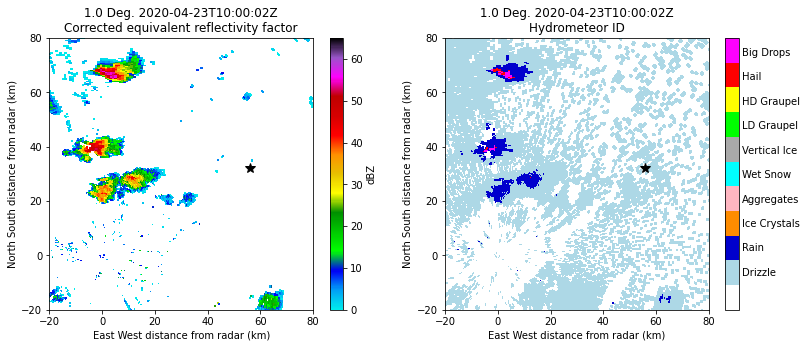

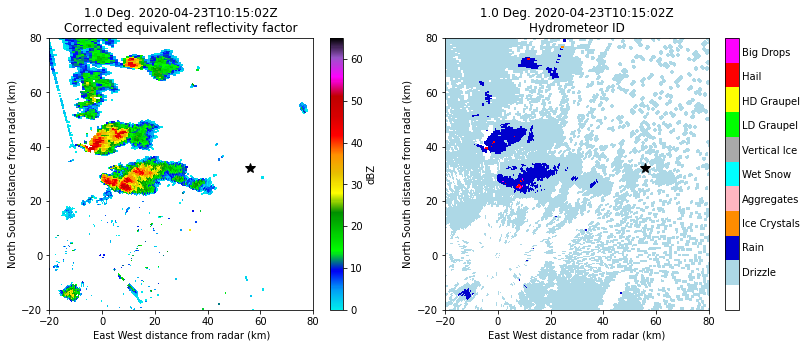

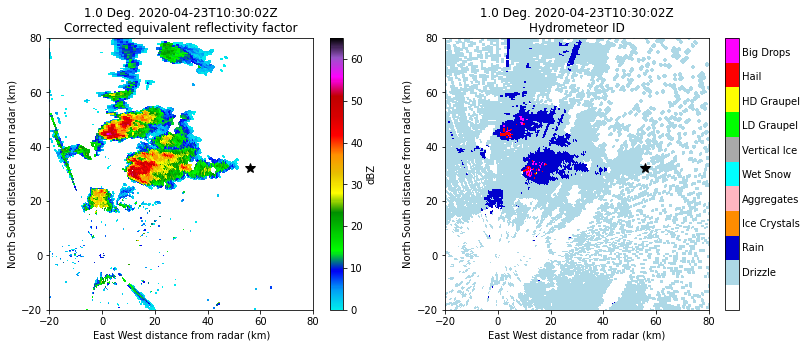

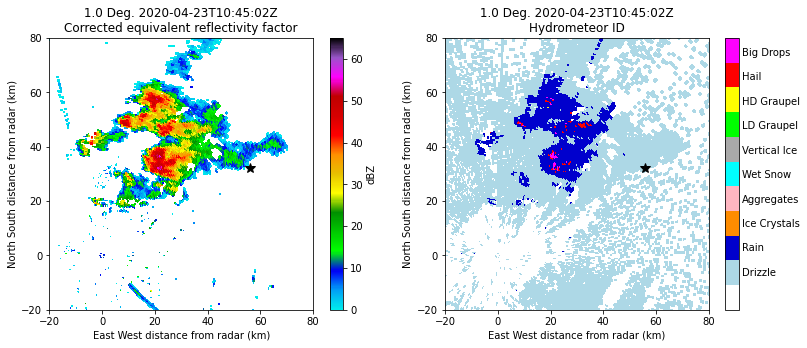

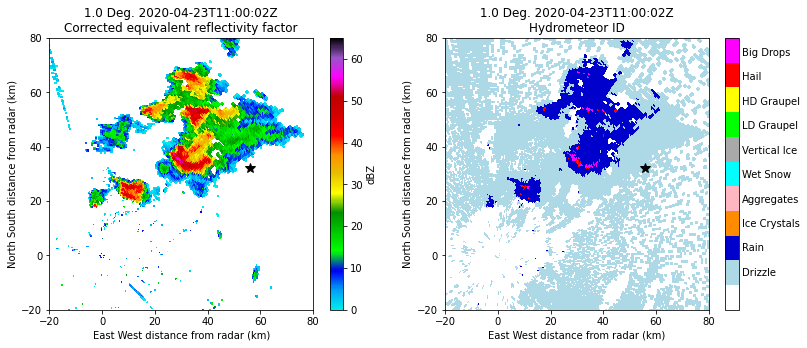

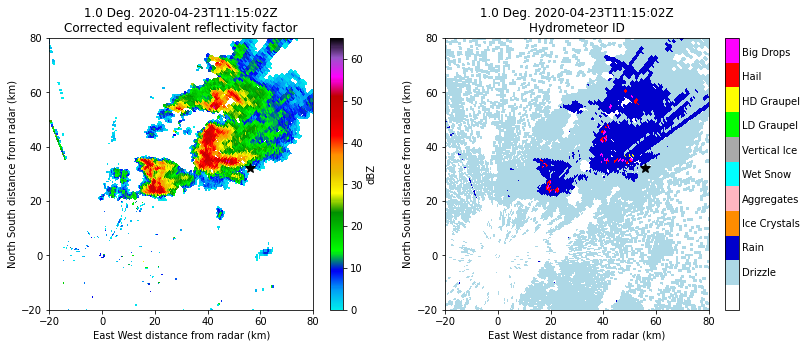

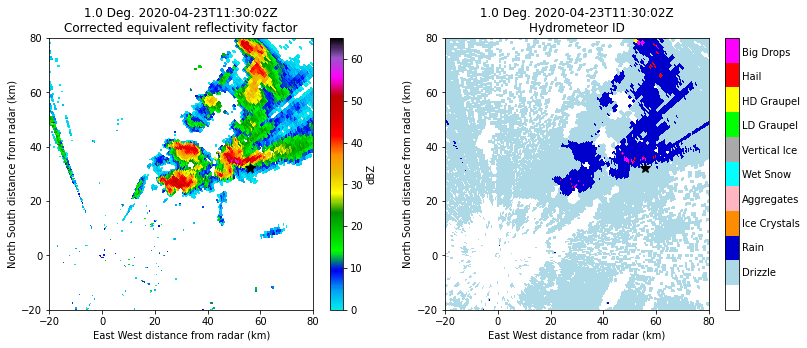

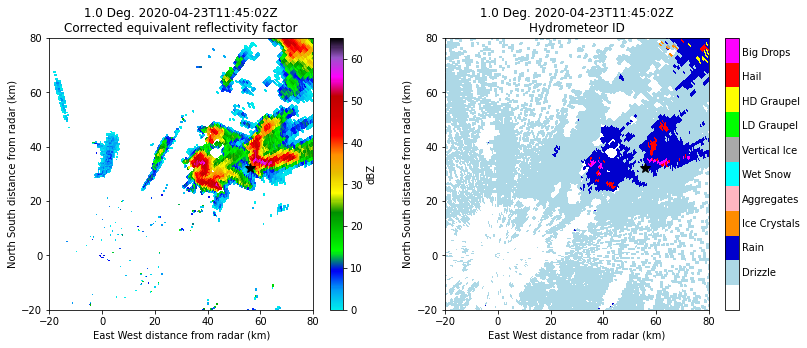

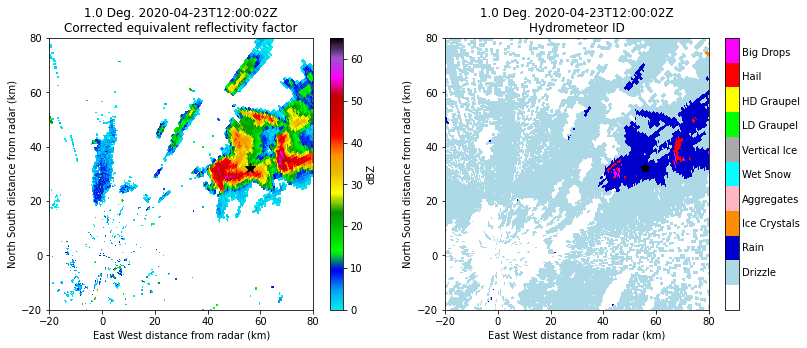

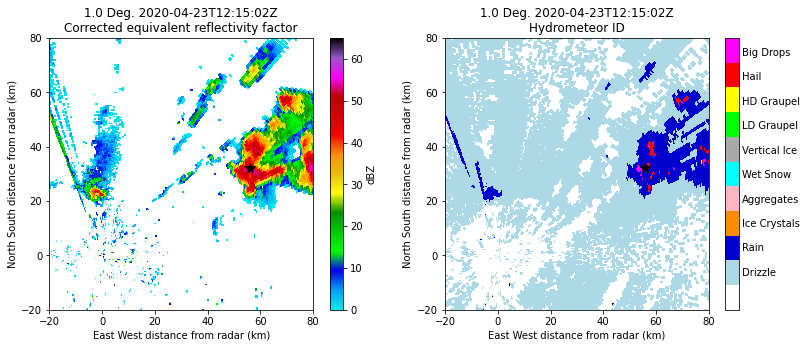

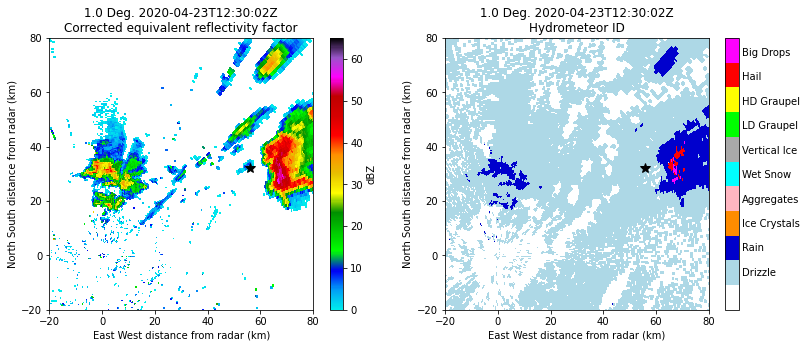

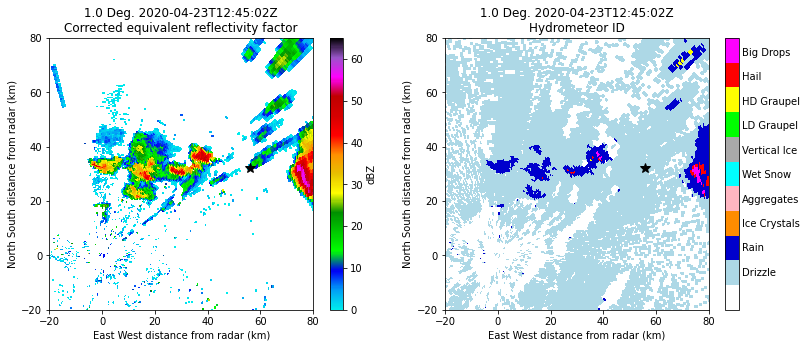

In [3]:
files = ['./0data/0Hail_CRI23Apr2020/CRI240@202004231000.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231015.uf',
         './0data/0Hail_CRI23Apr2020/CRI240@202004231030.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231045.uf',
        './0data/0Hail_CRI23Apr2020/CRI240@202004231100.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231115.uf',
        './0data/0Hail_CRI23Apr2020/CRI240@202004231130.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231145.uf',
        './0data/0Hail_CRI23Apr2020/CRI240@202004231200.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231215.uf',
        './0data/0Hail_CRI23Apr2020/CRI240@202004231230.uf', './0data/0Hail_CRI23Apr2020/CRI240@202004231245.uf']

lim = [-20, 80]
for file in files:
    print(file)
    radar ,gtfilter, fh, cmaphid, cmapmeth, cmapmeth_trop = classify_hydrometeor(file)   
    
    # พลอตภาพ
    plot_2panel(radar, lim, './0output/'+file[-9:-3]+'.png')